### **HIVE scRNAseq Analysis v1.3.2** ###
#### **Honeycomb Bioinformatics Team** ####
2023-10-06

#### **1 HIVE scRNAseq Analysis Vignette** ####
The document contains code and instructions to analyze single cell sequencing data generated by HIVE scRNAseq Solution. This analysis is intended as guidance to perform quality control, basic clustering and cell annotation for one experiments worth of samples. This example experiment has four samples where 7.5k or 30k cells were loaded into two HIVEs each (4 total HIVEs).

Please contact support@honeycomb.bio for all questions.

The below packages need to be installed prior to running this code. There may be additional dependencies required by these packages you may have to install depending on your R environment.

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(patchwork)
library(plyr)
library(Seurat)
library(UCell)
library(ggpubr)
library(SingleCellExperiment)
library(scuttle)
library(celldex)
library(DT)
library(scales)
library(UCell)
library(HGNChelper)
library(openxlsx)
})

Warning message:
“package ‘purrr’ was built under R version 4.3.1”
Warning message:
“package ‘lubridate’ was built under R version 4.3.1”
Warning message:
“package ‘plyr’ was built under R version 4.3.1”
Warning message:
“package ‘Seurat’ was built under R version 4.3.2”
Warning message:
“package ‘SeuratObject’ was built under R version 4.3.2”
Warning message:
“package ‘SingleCellExperiment’ was built under R version 4.3.2”
Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.3.2”
Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.2”
Warning message:
“package ‘GenomicRanges’ was built under R version 4.3.2”
Warning message:
“package ‘BiocGenerics’ was built under R version 4.3.2”
Warning message:
“package ‘S4Vectors’ was built under R version 4.3.2”
Warning message:
“package ‘IRanges’ was built under R version 4.3.2”
Warning message:
“package ‘GenomeInfoDb’ was built under R version 4.3.2”
Warning message:
“package ‘Biobase’ was built under

In [44]:
if (!requireNamespace("Seurat", quietly = TRUE)) {
  install.packages("Seurat")
}
if (!requireNamespace("dplyr", quietly = TRUE)) {
  install.packages("dplyr")
}
if (!requireNamespace("readr", quietly = TRUE)) {
  install.packages("readr")
}

library(Seurat)
library(dplyr)
library(readr)


#### **1.1 Finding Count Matrices and Setting Up Metadata** ####
Be sure that you specify the correct path to your count matrices, readQC, and sample QC files. If these files are not located in the current working directory, please provide the full path in quotation marks in the code below.

We recommend making a unique folder for your analysis. In this folder, we recommend making subfolders for each sample that contain all of the files necessary for this analysis. Here is an example of our recommended file tree, and the file tree that this tutorial is written for:




Please enter the sample names into the sampleslist argument below. The sample names in this list must match the sample names in the BeeNet output files. For example, if the transcription count matrix file is named MySample1_20230426182713_TCM.tsv.gz, then your sample name is MySample1. Furthermore, if you would like to compare samples based on a particular metadata, enter that metadata into the “groupslist”. Order matters! In this example, samples 1 and 2 were loaded with 7.5k cells, and samples 3 and 4 were loaded with 30k cells. Be sure to preserve the order when entering this data.

In [48]:
path_to <- "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_100/Beenet_SC_NP_H_7061"

In [53]:
rcm_path <- paste0(path_to, "/Beenet_SC_NP_H_7061_20240130123406_RCM.tsv.gz")
expression_data <- read_tsv(rcm_path, col_types = cols())

reads_qc_path <- paste0(path_to, "/Beenet_SC_NP_H_7061_20240130123406_ReadsQC.tsv")
reads_qc <- read_tsv(reads_qc_path, col_types = cols())

sample_qc_path <- paste0(path_to, "/Beenet_SC_NP_H_7061_20240130123406_SampleQC.tsv")
sample_qc <- read_tsv(sample_qc_path, col_types = cols())

tcm_path <- paste0(path_to, "/Beenet_SC_NP_H_7061_20240130123406_TCM.tsv.gz")
tcm_data <- read_tsv(tcm_path, col_types = cols())

cmsummary_path <- paste0(path_to, "/Beenet_SC_NP_H_7061_20240130123406_CMSummary.tsv")
cmsummary_data <- read_tsv(cmsummary_path, col_types = cols())


In [54]:
seurat_object <- CreateSeuratObject(counts = expression_data, project = "BeeNetAnalysis")

Warning message:
“Data is of class spec_tbl_df. Coercing to dgCMatrix.”
Warning message in matrix(data = as.numeric(x = x), ncol = nc):
“NAs introduced by coercion”


In [55]:
# Example of adding sample QC metadata
# Ensure column names in 'sample_qc' match cell names in 'seurat_object'
for(col in colnames(sample_qc)) {
  seurat_object <- AddMetaData(seurat_object, metadata = sample_qc[[col]], col.name = col)
}


In [56]:
head(seurat_object)

,orig.ident,nCount_RNA,nFeature_RNA,Total Reads,27542221
,<fct>,<dbl>,<int>,<chr>,<dbl>
_,BeeNetAnalysis,NA,NA,Filtered Reads,24257768
AAAAAACCCTGG,BeeNetAnalysis,295,26,Mapped Reads,21223627
AAAAAATATGAC,BeeNetAnalysis,542,11,Exon Reads,13017433
AAAAAGCTGGCT,BeeNetAnalysis,550,13,PolyA Read,560212
AAAACCTGCGGG,BeeNetAnalysis,1750,81,PF5 Reads,2712147
AAAACGTGCGAT,BeeNetAnalysis,694,10,PF3 Reads,12094
AAAAGCATGGAT,BeeNetAnalysis,296,4,Bad BC Reads,0
AAAAGCCCACTT,BeeNetAnalysis,478,9,Filtered Reads,24257768
AAAAGCCGTATG,BeeNetAnalysis,1319,34,Mapped Reads,21223627


In [57]:
head(seurat_object@meta.data)


,orig.ident,nCount_RNA,nFeature_RNA,Total Reads,27542221
,<fct>,<dbl>,<int>,<chr>,<dbl>
_,BeeNetAnalysis,NA,NA,Filtered Reads,24257768
AAAAAACCCTGG,BeeNetAnalysis,295,26,Mapped Reads,21223627
AAAAAATATGAC,BeeNetAnalysis,542,11,Exon Reads,13017433
AAAAAGCTGGCT,BeeNetAnalysis,550,13,PolyA Read,560212
AAAACCTGCGGG,BeeNetAnalysis,1750,81,PF5 Reads,2712147
AAAACGTGCGAT,BeeNetAnalysis,694,10,PF3 Reads,12094


In [58]:
head(GetAssayData(seurat_object, slot = "counts"))


Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”
  [[ suppressing 6001 column names ‘_’, ‘AAAAAACCCTGG’, ‘AAAAAATATGAC’ ... ]]



6 x 6001 sparse Matrix of class "dgCMatrix"
                                                                              
1 NA . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
2 NA . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
3 NA . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
4 NA . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
5 NA . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
6 NA . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
                                                                               
1 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
2 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
3 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
4 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
5 .

In [59]:
head(rownames(seurat_object))


[1] "1" "2" "3" "4" "5" "6"

In [60]:
head(colnames(seurat_object))


[1] "_"            "AAAAAACCCTGG" "AAAAAATATGAC" "AAAAAGCTGGCT" "AAAACCTGCGGG"
[6] "AAAACGTGCGAT"

In [64]:
seurat_object <- NormalizeData(seurat_object, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



In [65]:
seurat_object <- ScaleData(seurat_object)

Centering and scaling data matrix



In [68]:
seurat_object <- FindVariableFeatures(seurat_object, selection.method = "vst", nfeatures = 2000)

Finding variable features for layer counts



ERROR: Error in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, : invalid 'x'


In [67]:
seurat_object <- RunPCA(seurat_object, features = VariableFeatures(object = seurat_object))

ERROR: Error: No variable features, run FindVariableFeatures() or provide a vector of features


In [34]:
# Normalization
seurat_object <- NormalizeData(seurat_object, normalization.method = "LogNormalize", scale.factor = 10000)

# Find variable features
seurat_object <- FindVariableFeatures(seurat_object, selection.method = "vst", nfeatures = 2000)


Normalizing layer: counts

Finding variable features for layer counts



Centering and scaling data matrix

PC_ 1 
Positive:  Feature9245, Feature9244, Feature8788, Feature4546, Feature9255, Feature61, Feature13174, Feature1002, Feature12600, Feature12921 
	   Feature5912, Feature15365, Feature8815, Feature2063, Feature5857, Feature5055, Feature13551, Feature11915, Feature5696, Feature7582 
	   Feature4013, Feature3736, Feature2523, Feature3950, Feature11794, Feature14420, Feature5106, Feature9096, Feature5431, Feature353 
Negative:  Feature963, Feature12502, Feature12433, Feature9968, Feature601, Feature14731, Feature14829, Feature1485, Feature1530, Feature6705 
	   Feature14839, Feature14928, Feature7130, Feature1488, Feature14551, Feature3229, Feature6717, Feature11285, Feature2704, Feature6256 
	   Feature13437, Feature7048, Feature12375, Feature12709, Feature14873, Feature9402, Feature12358, Feature1813, Feature2153, Feature10604 
PC_ 2 
Positive:  Feature963, Feature12502, Feature6705, Feature14839, Feature14873, Feature14829, Feature1530, Feature1473

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6000
Number of edges: 159210

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8864
Number of communities: 13
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:19:40 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:19:40 Read 6000 rows and found 10 numeric columns

15:19:40 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

15:19:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:19:41 Writing NN index file to t

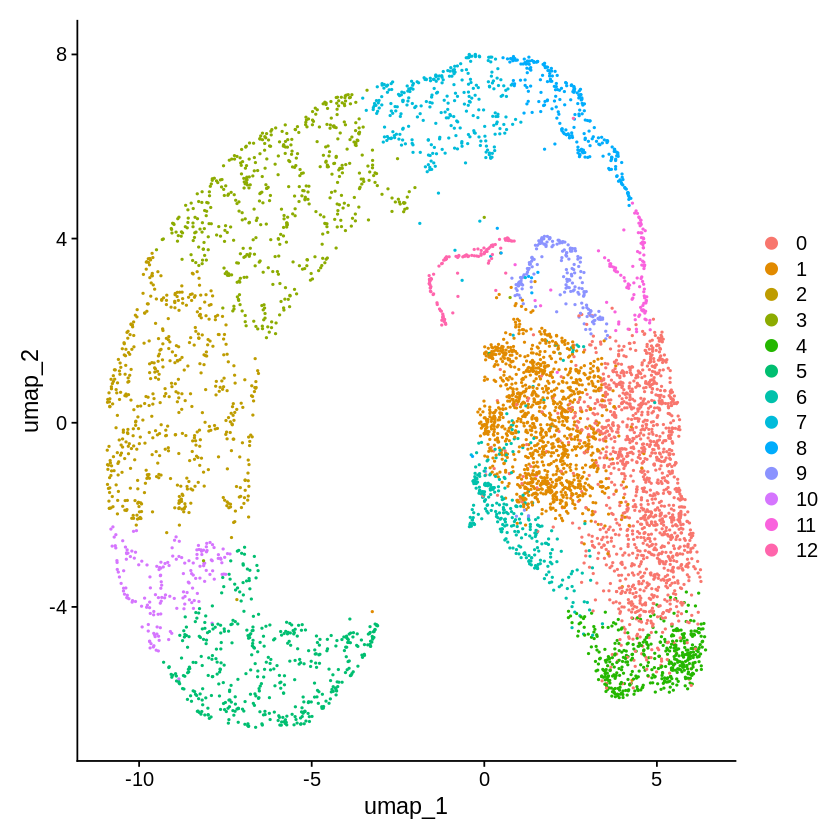

In [36]:
# Scale the data
seurat_object <- ScaleData(seurat_object)

# Now, run PCA
seurat_object <- RunPCA(seurat_object, features = VariableFeatures(object = seurat_object))

# Find neighbors
seurat_object <- FindNeighbors(seurat_object, dims = 1:10)

# Cluster cells
seurat_object <- FindClusters(seurat_object, resolution = 0.5)

# Run UMAP
seurat_object <- RunUMAP(seurat_object, dims = 1:10)

# Visualize the UMAP
DimPlot(seurat_object, reduction = "umap")



In [37]:
# Find marker genes
markers <- FindAllMarkers(seurat_object, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

# View top 10 markers per cluster
head(markers, 10)


Calculating cluster 0

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”
Calculating cluster 2

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
“No features pass logfc.threshold threshold; returning empty data.frame”
Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calcul

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Feature9271,7.805444e-05,0.2656160,0.332,0.280,1.000000e+00,0,Feature9271
Feature9235,3.638335e-03,0.2838506,0.622,0.599,1.000000e+00,3,Feature9235
Feature8594,2.042394e-248,3.7789307,0.767,0.155,3.283352e-244,4,Feature8594
Feature7130,5.723484e-218,4.3195230,0.332,0.019,9.201073e-214,4,Feature7130
Feature963,6.873054e-213,4.6247331,0.302,0.015,1.104912e-208,4,Feature963
Feature1530,1.214331e-209,4.2652016,0.330,0.020,1.952158e-205,4,Feature1530
Feature14839,1.846730e-204,3.5572889,0.327,0.021,2.968803e-200,4,Feature14839
Feature14731,1.497330e-191,4.9572674,0.264,0.012,2.407108e-187,4,Feature14731
Feature11285,6.848522e-189,3.6229062,0.287,0.016,1.100968e-184,4,Feature11285


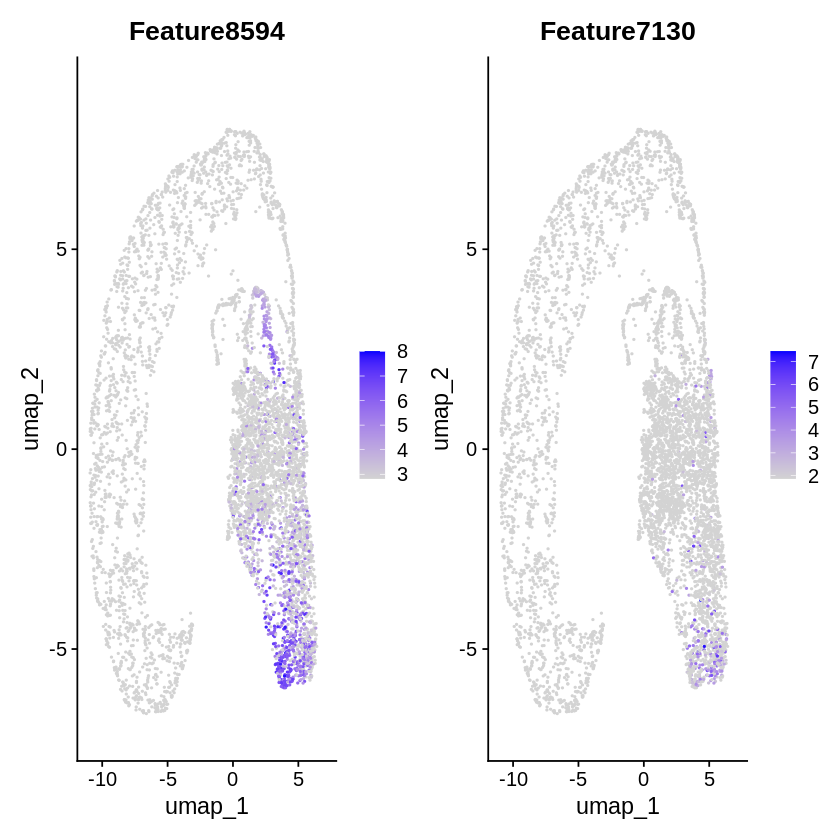

In [38]:
# Replace 'Feature8594', 'Feature7130', etc., with the actual gene names if available
FeaturePlot(seurat_object, features = c("Feature8594", "Feature7130"), min.cutoff = "q9")


Warning message in `[<-.factor`(`*tmp*`, new.ident == "4", value = "T cells"):
“invalid factor level, NA generated”


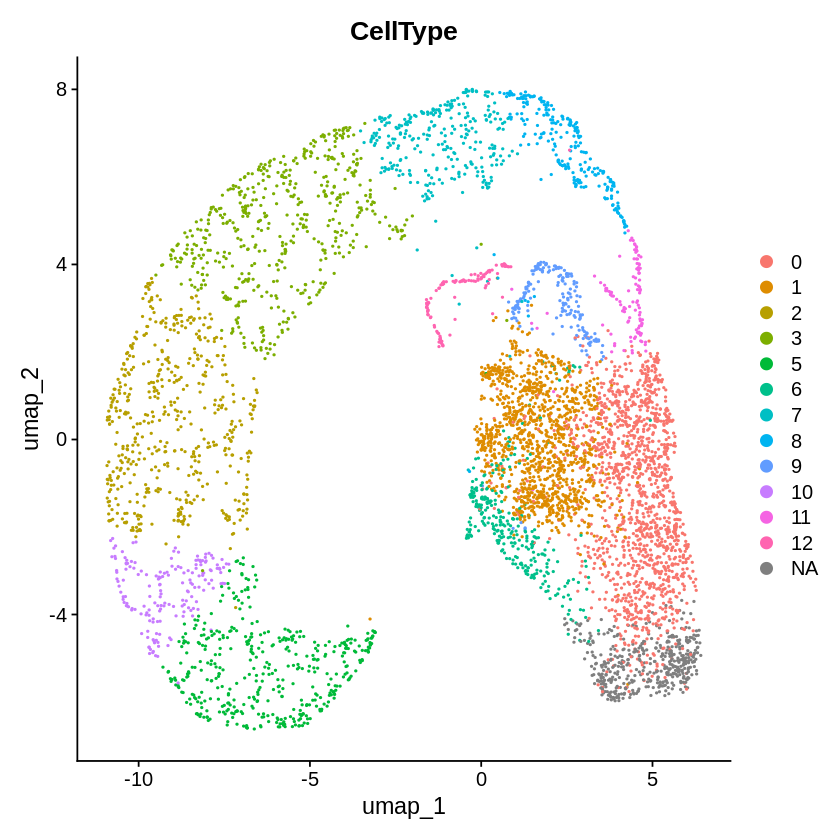

In [39]:
# This is a hypothetical example. Replace with your actual data and annotations.
# Let's say cluster 4 is identified as a specific cell type, e.g., T cells
new.ident <- seurat_object$seurat_clusters
new.ident[new.ident == "4"] <- "T cells"  # Assuming cluster 4 is T cells
seurat_object <- AddMetaData(seurat_object, metadata = new.ident, col.name = "CellType")

# Now, you can visualize the clusters with the new annotations
DimPlot(seurat_object, reduction = "umap", group.by = "CellType")


In [40]:
# Find differentially expressed genes between clusters
cluster1_vs_cluster2 <- FindMarkers(seurat_object, ident.1 = "1", ident.2 = "2")  # Replace with actual cluster IDs

# View the top differentially expressed genes
head(cluster1_vs_cluster2)


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Feature9245,2.307775e-52,-0.1182030,1.000,1.000,3.709979e-48
Feature8594,2.671230e-19,13.0859006,0.140,0.000,4.294269e-15
Feature9236,2.435621e-04,0.4823696,0.615,0.524,1.000000e+00
Feature9240,5.820674e-04,0.3383397,0.775,0.726,1.000000e+00
Feature9243,7.549225e-04,0.3652650,0.103,0.052,1.000000e+00
Feature12180,1.663220e-03,9.3839216,0.019,0.000,1.000000e+00


In [30]:
# Set the paths to the directories containing your files
base_path_1 <- "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_100/Beenet_SC_NP_H_7061"
base_path_2 <- "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_100/Beenet_SC_NP_H_7063"

# Combine both base paths into a list
base_paths <- list(base_path_1, base_path_2)

# Initialize empty lists to store file paths
CMfiles <- list()
readsFiles <- list()
samplesFiles <- list()

# Iterate over each base path
for (base_path in base_paths) {
  # Transcript count matrix files
  CMfiles_tmp <- list.files(path = base_path, pattern = "TCM.tsv.gz", full.names = TRUE)
  CMfiles <- c(CMfiles, CMfiles_tmp)

  # ReadsQC files
  readsFiles_tmp <- list.files(path = base_path, pattern = "ReadsQC.tsv", full.names = TRUE)
  readsFiles <- c(readsFiles, readsFiles_tmp)

  # SampleQC files
  samplesFiles_tmp <- list.files(path = base_path, pattern = "SampleQC.tsv", full.names = TRUE)
  samplesFiles <- c(samplesFiles, samplesFiles_tmp)
}

# Print the lists of files
print("Transcript count matrix files:")
print(CMfiles)

print("ReadsQC files:")
print(readsFiles)

print("SampleQC files:")
print(samplesFiles)

# Replace sample names below with the name of your sample. Make sure that the order of the samples and the order of the groups are correct!
sampleslist <- c("SC_NP_H_7061", "SC_NP_H_7063") # Corrected to include both samples
groupslist <- c("15k", "15k")



# Print the lists of samples and groups
print("Sample list:")
print(sampleslist)

print("Groups list:")
print(groupslist)


[1] "Transcript count matrix files:"
[[1]]
[1] "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_100/Beenet_SC_NP_H_7061/Beenet_SC_NP_H_7061_20240130123406_TCM.tsv.gz"

[[2]]
[1] "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Beenet_SC_NP_H_100/Beenet_SC_NP_H_7063/Beenet_SC_NP_H_7063_20240130124651_TCM.tsv.gz"

[1] "ReadsQC files:"
[[1]]
[1] "/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/1_Example_Data_for_BeeNetPLUS/1_Practice_running_BeeNetPLUS_using_this_dataset/BeeNetOutputs/Bee

You should now see a list of your count matrices files and your readsQC files in your R environment

##### **1.2 Read Count Matrices and Create a Seurat Object for each sample** #####
Here we define a function called generate_seurat_object() to create Seurat objects from the BeeNet Outputs. This function reads in count matrices and adds metadata to your Seurat object.

In [3]:
# Function to generate Seurat object
generate_seurat_object <- function(sample, group_name = "", CMfiles, readsFiles){
  
  # Find matching file paths for CM and Reads files
  CMfile_matches <- grep(sample, CMfiles, value = TRUE)
  readsFile_matches <- grep(sample, readsFiles, value = TRUE)

  # Check if exactly one matching file is found for each type
  if(length(CMfile_matches) != 1) {
    stop("Expected one matching CM file for sample '", sample, "', but found ", length(CMfile_matches))
  }
  if(length(readsFile_matches) != 1) {
    stop("Expected one matching Reads file for sample '", sample, "', but found ", length(readsFile_matches))
  }

  # Use the matched file paths
  CMfile_path <- CMfile_matches[1]
  readsFile_path <- readsFile_matches[1]

  # Load count matrix file
  dataTran <- read.table(CMfile_path, header = TRUE, row.names = 1, check.names = FALSE, sep = "\t", quote = "", stringsAsFactors = FALSE) 
  
  # Load read info for each barcode
  dataReads <- read.table(readsFile_path, header = TRUE, row.names = 1)
  
  # Ensure order of read info matches order of TCM matrix
  table(rownames(dataReads) == colnames(dataTran))
  reads = dataReads[rownames(dataReads) %in% colnames(dataTran),]

  # Create a Seurat Object
  obj <- CreateSeuratObject(counts = dataTran, project = sample)
  
  # Calculate metadata info
  logtotreads <- log10(as.matrix(reads)[,1])
  readAll <- dataReads[,1]
  readMap <- reads[,2]
  readMapPct <- readMap / readAll
  readUnmap <- readAll - readMap
  readUnmapPct <- readUnmap / readAll
  readExon <- reads[,3]
  readExonPct <- readExon / readAll
  readExonMapPct <- readExon / readMap
  names(readExon) <- colnames(obj)
  obj <- AddMetaData(obj, readExon, "ExonReads")
  names(readExonMapPct) <- colnames(obj)
  names(readExonPct) <- colnames(obj)
  names(readMap) <- colnames(obj)
  names(readAll) <- colnames(obj)
  
  # Add metadata to object
  obj <- AddMetaData(obj, logtotreads, "Log.TotReads") 
  obj <- AddMetaData(obj, readExonMapPct, "ExonvMapped")
  obj <- AddMetaData(obj, readExonPct, "ExonvTotal")
  obj <- AddMetaData(obj, readMap, "reads.mapped")
  obj <- AddMetaData(obj, readAll, "reads.Total")

  # Calculate complexity and add to metadata
  comp = obj@meta.data$ExonReads / obj@meta.data$nCount_RNA
  names(comp) <- rownames(obj@meta.data)
  obj <- AddMetaData(obj, comp, "Complexity")
  
  # Add group and groupSamp
  obj$group <- group_name
  obj$groupSamp <- paste(group_name, sample, sep = "_")

  return(obj)
}

Next, run the function on each sample to generate a seurat object for each sample. From there, merge the individual objects into a final objects and remove the individual objects.

In [4]:
# Generate Seurat objects for each sample
seurat_list <- purrr::map2(sampleslist, groupslist, 
                    ~ generate_seurat_object(sample = .x,
                                             group_name = .y,
                                             CMfiles = CMfiles,
                                             readsFiles = readsFiles))

# Merge individual objects into a final Seurat object if more than one sample
if(length(seurat_list) > 1) {
  obj <- merge(x = seurat_list[[1]], 
               y = seurat_list[2:length(seurat_list)], 
               add.cell.ids = sampleslist)
} else {
  obj <- seurat_list[[1]]
}

# Remove seurat_list to clear up memory
remove(seurat_list)


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”
Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


##### **1.3 Filtering Cells** #####
We removed cells with:

Fewer than 300 genes
Fewer than 600 unique transcript molecules.
This will be highly sample dependent. If you find that you lose too many cells filtering with these thresholds, we recommend filtering with a lower threshold (50 genes/100 transcripts) and then removing low quality clusters.

In [5]:
## determine how many cells are recovered before filtering
ncol(obj)

[1] 12000

In [6]:
## filter features that have less than 300 genes and 600 unique transcript molecules
nGeneI=300
nTranI=600
obj <- subset(obj, subset = nFeature_RNA > nGeneI & nCount_RNA > nTranI)
obj

An object of class Seurat 
16076 features across 55 samples within 1 assay 
Active assay: RNA (16076 features, 0 variable features)
 1 layer present: counts.SC_NP_H_7061

In [7]:
## determine how many cells are recovered after filtering
ncol(obj)

[1] 55

In [11]:
obj

An object of class Seurat 
16076 features across 55 samples within 1 assay 
Active assay: RNA (16076 features, 0 variable features)
 1 layer present: counts.SC_NP_H_7061

##### **1.4 Quality Control** #####
###### **1.4.1 QC** ######

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


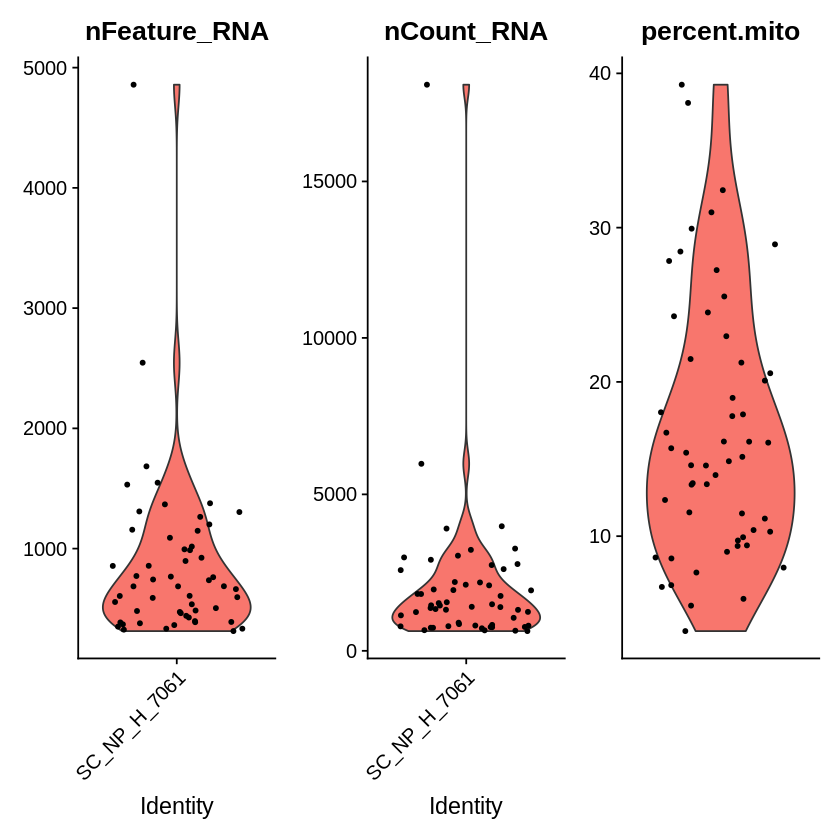

In [8]:
# Add mitochondrial content
# Adjust the pattern based on your mitochondrial gene names
obj[["percent.mito"]] <- PercentageFeatureSet(obj, pattern = "^MT-")

# Identify mitochondrial genes - adjust the patterns based on your reference genome
mito.genes <- grep("^MT\\.", rownames(obj@assays$RNA), value = TRUE)
mito.genes <- c(mito.genes, grep("^MT-", rownames(obj@assays$RNA), value = TRUE))

# Plot the QC metrics in a violin plot with scatter data
VlnPlot(obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mito"), 
        pt.size = 1, # Adjust the point size as needed
        ncol = 3, 
        combine = TRUE) +  # Combine violin and scatter plots
  theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank())

###### **1.4.1.2 QC - Scatter Plots** ######

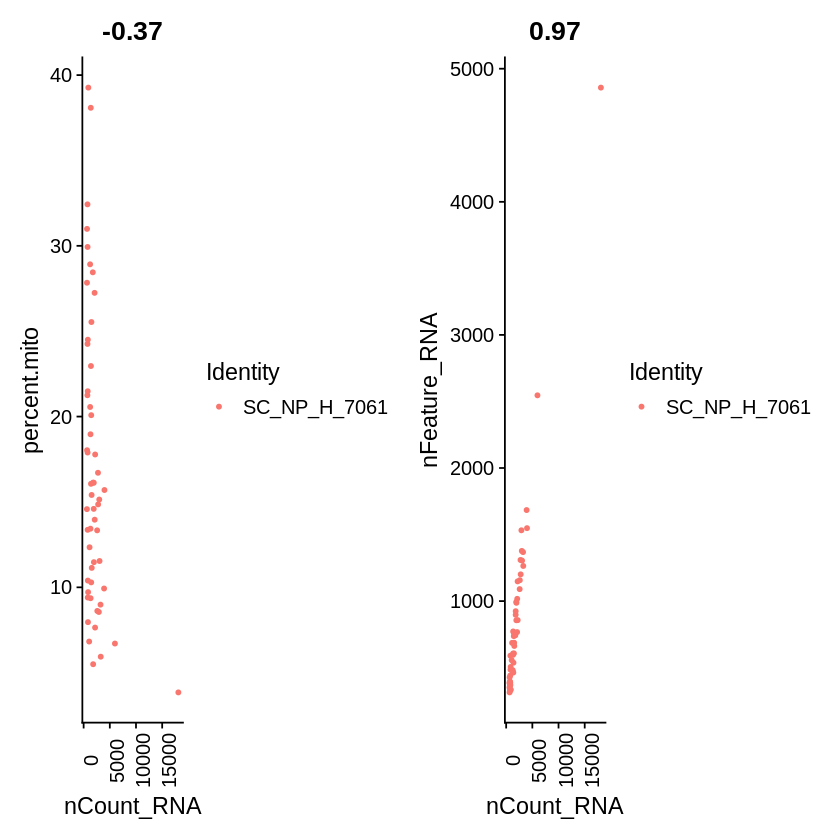

In [9]:
## plot scatter QC 
plot1 <- FeatureScatter(obj, feature1 = "nCount_RNA", feature2 = "percent.mito") + 
  theme(axis.text.x = element_text(angle = 90))
plot2 <- FeatureScatter(obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + 
  theme(axis.text.x = element_text(angle = 90))

plot1 + plot2

In [23]:
summary(obj)

Length  Class   Mode 
     1 Seurat     S4 

###### **1.4.1.3 QC - QC Metrics by Sample** ######
Use the qc_metrics_sample function below to obtain a table containing quality metrics for each sample. Rerun this function every time you remove or subset cells, or change the gene/threshold parameters.



In [28]:
##Set the Identity of the cells to the seurat cluster

DimPlot(obj, reduction="umap")

ERROR: [1m[33mError[39m in `object[[reduction]]`:[22m
[33m![39m ‘umap’ not found in this Seurat object
 


In [25]:
# Assuming sampleslist and samplesFile are defined earlier in your code

# Load Total read info
# totReads.df <- data.frame()

# for (sample in sampleslist) {
#   file_matches <- grep(sample, samplesFile, value = TRUE)
  
#   # Check if there are valid file matches
#   if (length(file_matches) == 0) {
#     warning("No files found for sample: ", sample)
#     next
#   }

#   sampleqcinfo <- read.table(file_matches[1], sep = "\t", header = TRUE)
#   specs <- sampleqcinfo[, 1]
#   totReads.df <- cbind(totReads.df, sampleqcinfo[, 2])
#   row.names(totReads.df) <- specs
# }

# # Check if totReads.df is not empty before setting column names
# if (ncol(totReads.df) > 0) {
#   colnames(totReads.df) <- sampleslist
# } else {
#   warning("No valid data found. Check your file paths and contents.")
# }

# # Define the quality control metrics function
# qc_metrics_sample <- function(obj) {
#   I = obj@meta.data$orig.ident
#   I  
#   Reads = obj@meta.data$ExonReads
#   ReadsM = obj@meta.data$reads.mapped
#   ReadsT = obj@meta.data$reads.Total
#   trans = obj@meta.data$nCount_RNA
#   Genes = obj@meta.data$nFeature_RNA
#   Mito = obj@meta.data$percent.mito
#   Complexity = obj@meta.data$Complexity
  
#   nSamples = length(sampleslist)
#   readEC = vector(mode = "double", length = nSamples)
#   readsTot = totReads.df
#   readsTotalSamples = colnames(readsTot)
#   names(readEC) = sampleslist
#   readTC = readEC
#   readMC = readEC
#   transC = readEC
#   geneC = readEC
#   mitoC = readEC
#   nCells = readEC
#   compl = readEC
#   readsCellTotal = readEC
#   readsSampleTotal = readEC
#   FracCellReads = readEC
#   readsSampleMapped = readEC
#   readsSampleFiltered = readEC
#   readsSampleExon = readEC
#   percExon = readEC
#   percFilt = readEC

#   for (x in 1:nSamples) {
#     readTC[x] = median(ReadsT[is.na(match(I, sampleslist[x])) == 0])
#     readEC[x] = median(Reads[is.na(match(I, sampleslist[x])) == 0])
#     readMC[x] = median(ReadsM[is.na(match(I, sampleslist[x])) == 0])
#     transC[x] = median(trans[is.na(match(I, sampleslist[x])) == 0])
#     geneC[x] = median(Genes[is.na(match(I, sampleslist[x])) == 0])
#     mitoC[x] = median(Mito[is.na(match(I, sampleslist[x])) == 0])
#     compl[x] = median(Complexity[is.na(match(I, sampleslist[x])) == 0])
#     nCells[x] = sum(is.na(match(I, sampleslist[x])) == 0)
#     readsCellTotal[x] = sum(ReadsT[is.na(match(I, sampleslist[x])) == 0])
#     readsSampleTotal[x] = readsTot[1, is.na(match(readsTotalSamples, sampleslist[x])) == 0]
#     FracCellReads[x] = readsCellTotal[x] / readsSampleTotal[x]
#     readsSampleMapped[x] = readsTot[3, is.na(match(readsTotalSamples, sampleslist[x])) == 0]
#     readsSampleFiltered[x] = readsTot[2, is.na(match(readsTotalSamples, sampleslist[x])) == 0]
#     readsSampleExon[x] = readsTot[4, is.na(match(readsTotalSamples, sampleslist[x])) == 0]
#     percExon[x] = readEC[x] / readTC[x] * 100
#     percFilt[x] = readsSampleFiltered[x] / readsSampleTotal[x]
#   }

#   clustInfo = data.frame(SampleID = sampleslist, Group = groupslist, TotalReads = readTC,
#                          MappedReads = readMC, ExonReads = readEC, nTrans = transC,
#                          nGenes = geneC, percMito = mitoC, nCells = nCells,
#                          Complexity = compl, SampleTotalReads = readsSampleTotal,
#                          SampleFilteredReads = readsSampleFiltered,
#                          SampleMappedReads = readsSampleMapped, SampleExonReads = readsSampleExon,
#                          HQCellsTotalReads = readsCellTotal, FracReadsHQCells = FracCellReads,
#                          PctExon = percExon, FracPassFilter = percFilt)
  
#   write.table(clustInfo, "SamplesMetrics.txt", sep = "\t", col.names = NA)
  
#   return(clustInfo)
# }

# Call the function with your Seurat object
# sample_metrics <- qc_metrics_sample(obj)
# sample_metrics
# Assuming you have 'datatable' from DT package for displaying the data frame
# datatable(sample_metrics)

###### **1.4.1.4 QC - Sequencing Plots** ######

In [26]:
colors=rep(c("#ED7D30","#0058D4", "#7D3C98", "#F4D03F", "#16A085", "#721236", 
             "#A0CBE8", "#FFBE7D", "#59A14F", "#FF9D9A", "#79706E", "#8CD17D", 
             "#499894", "#BAB0AC", "#D37295", "#FABFD2", "#B07AA1"),5)

p <- ggplot(sample_metrics, aes(Group, SampleTotalReads)) + 
  ggtitle("Total Sample Reads by Group") 

# calculate axis limits for plots
d=floor(log(max(sample_metrics$SampleTotalReads),10))
yL=ceiling(max(sample_metrics$SampleTotalReads)/10^d)*10^d

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

ERROR: [1m[33mError[39m in `fortify()`:[22m
[1m[22m[33m![39m `data` must be a [34m<data.frame>[39m, or an object coercible by `fortify()`,
  not a character vector.


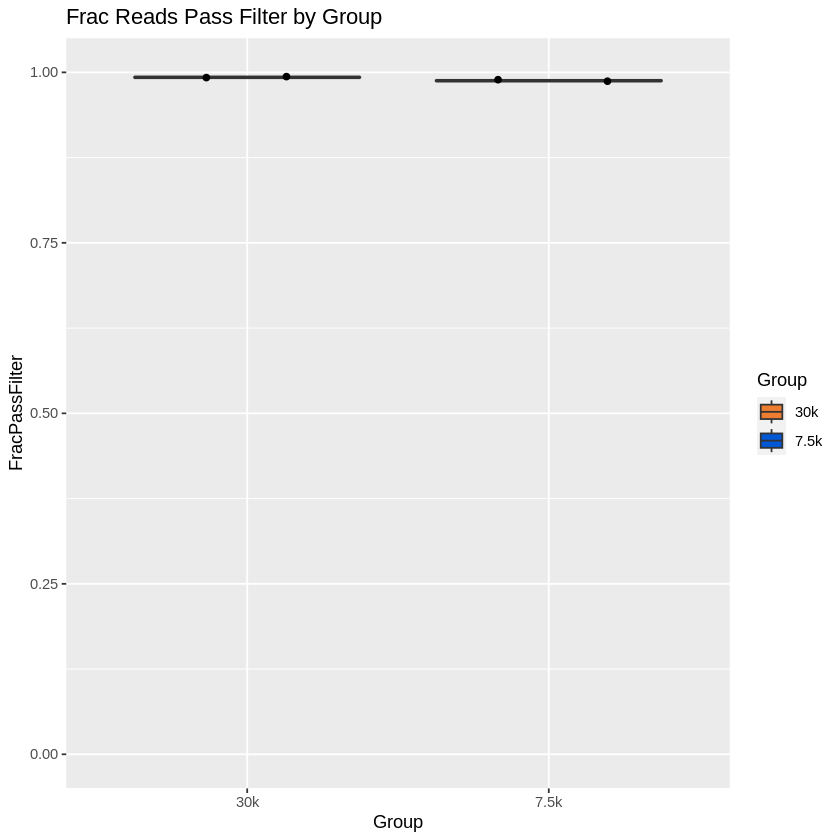

In [17]:
p <- ggplot(sample_metrics, aes(Group, FracPassFilter)) + 
  ggtitle("Frac Reads Pass Filter by Group")

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,1))

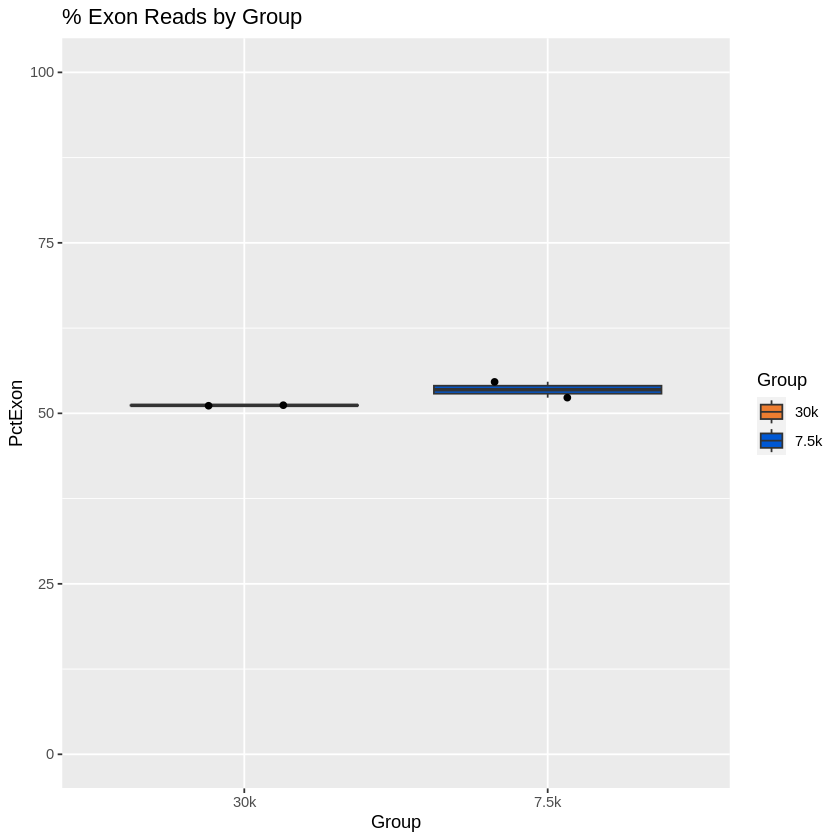

In [18]:
p <- ggplot(sample_metrics, aes(Group, PctExon)) + 
  ggtitle("% Exon Reads by Group")

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,100)) 


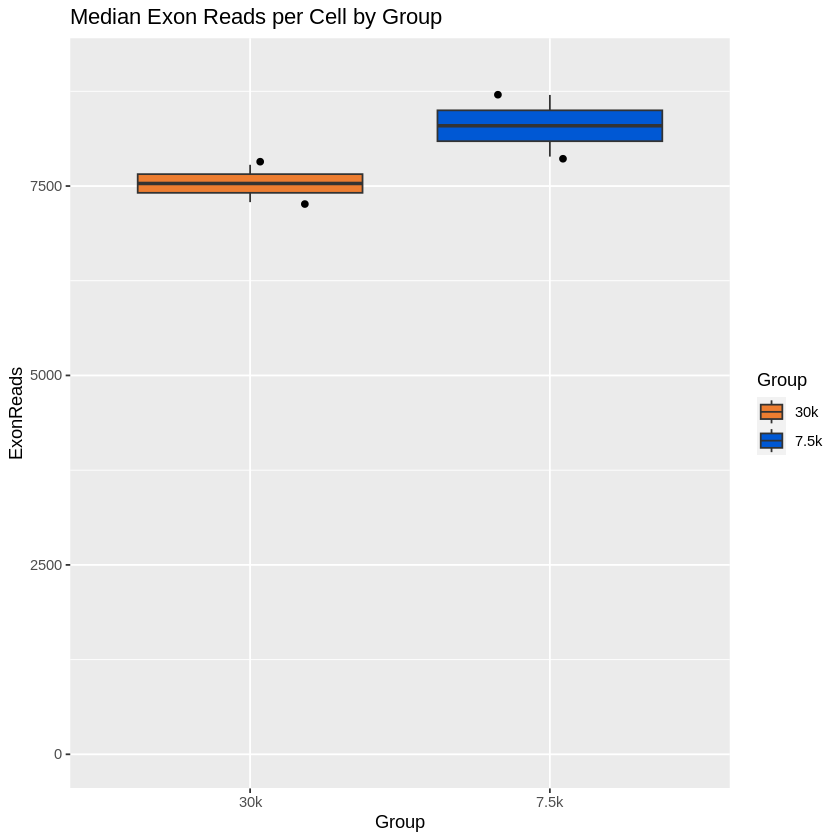

In [19]:
p <- ggplot(sample_metrics, aes(Group, ExonReads)) + 
  ggtitle("Median Exon Reads per Cell by Group")

# calculate axis limits for plots
d=floor(log(max(sample_metrics$ExonReads),10))
yL=ceiling(max(sample_metrics$ExonReads)/10^d)*10^d

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 


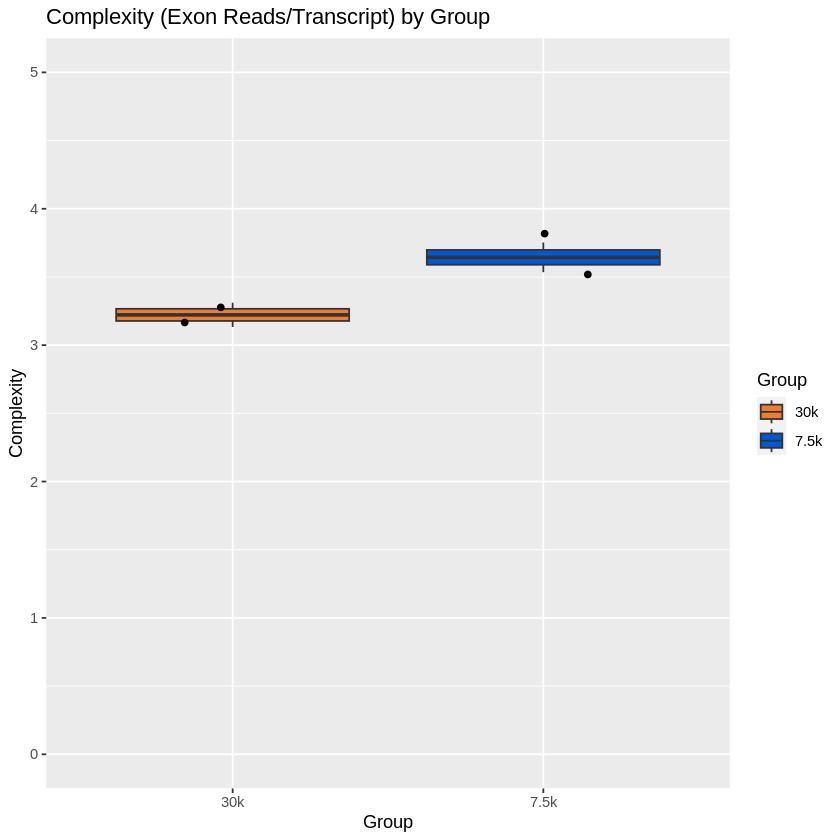

In [20]:
p <- ggplot(sample_metrics, aes(Group, Complexity)) + 
  ggtitle("Complexity (Exon Reads/Transcript) by Group")

# calculate axis limits for plots
yL=5*ceiling(max(sample_metrics$Complexity)/5)

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

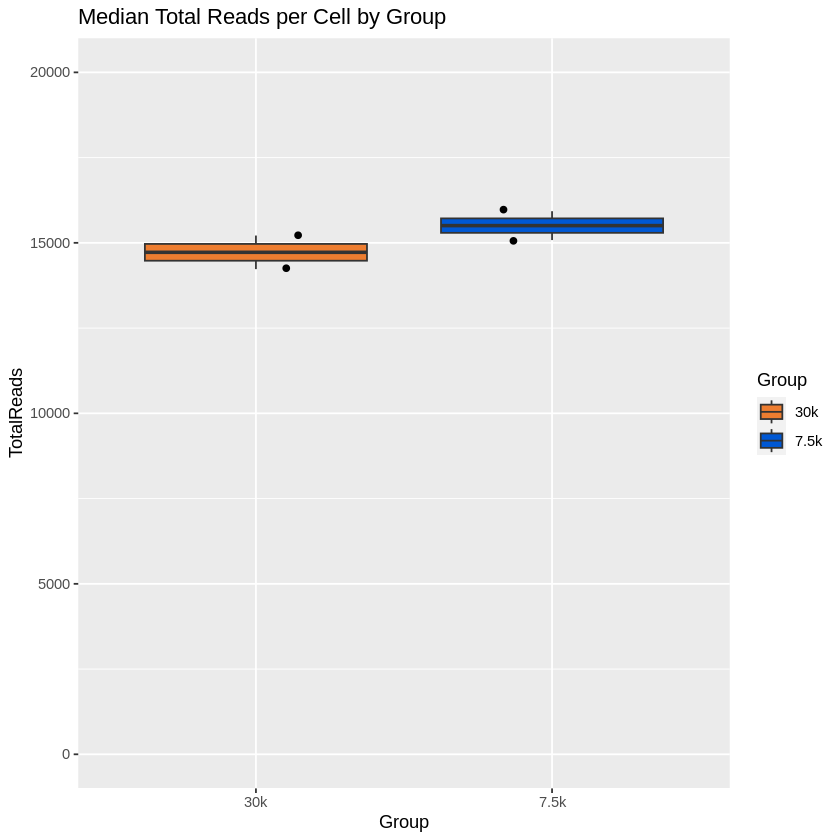

In [21]:
p <- ggplot(sample_metrics, aes(Group, TotalReads)) + 
  ggtitle("Median Total Reads per Cell by Group")

# calculate axis limits for plots
d=floor(log(max(sample_metrics$TotalReads),10))
yL=ceiling(max(sample_metrics$TotalReads)/10^d)*10^d

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

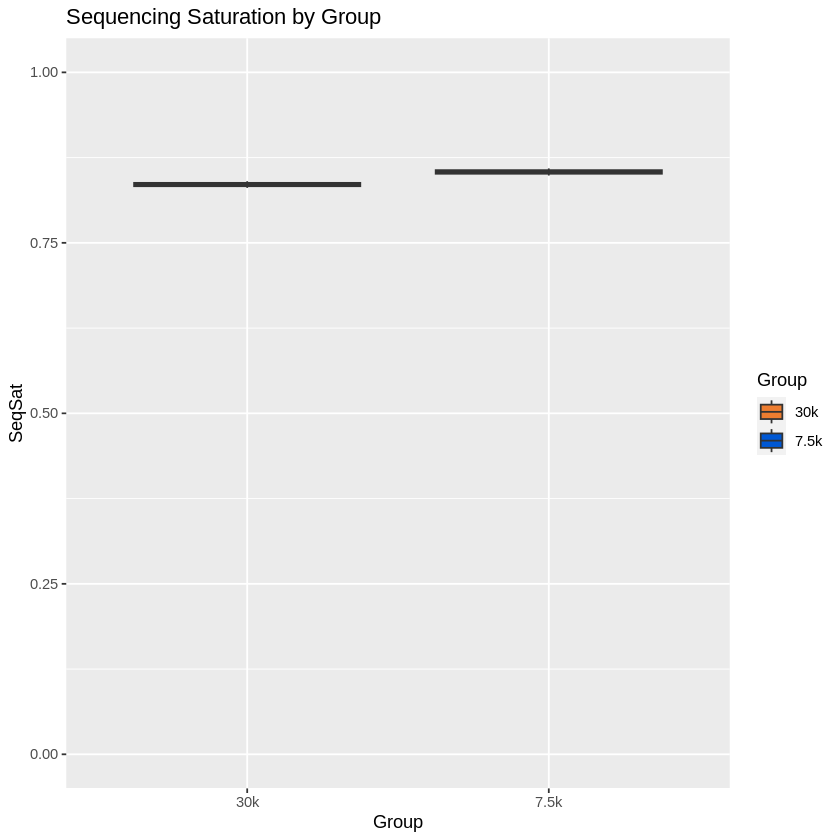

In [22]:
p <- ggplot(sample_metrics, aes(Group, SeqSat)) + 
  ggtitle("Sequencing Saturation by Group")

yL=100

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  ylim(c(0,1)) 


##### **1.4.2 Cell Recovery** #####
Using your sample metrics table, make plots to display cell/gene/transcript recovery. In this example, only 1/8 of the HIVE was sequenced, so cell recovery is 1/8 of what would be expected for these samples.

Here are a few things to look for in your data.

Median Genes by Group: > 800. This number is sample dependent. It is usually higher for cell lines and lower for samples that contain granulocytes.

Median Transcripts by Group: > 1200. This number is sample dependent. It is usually higher for cell lines and lower for samples that contain granulocytes.

Percent Mito by Group: < 20%.

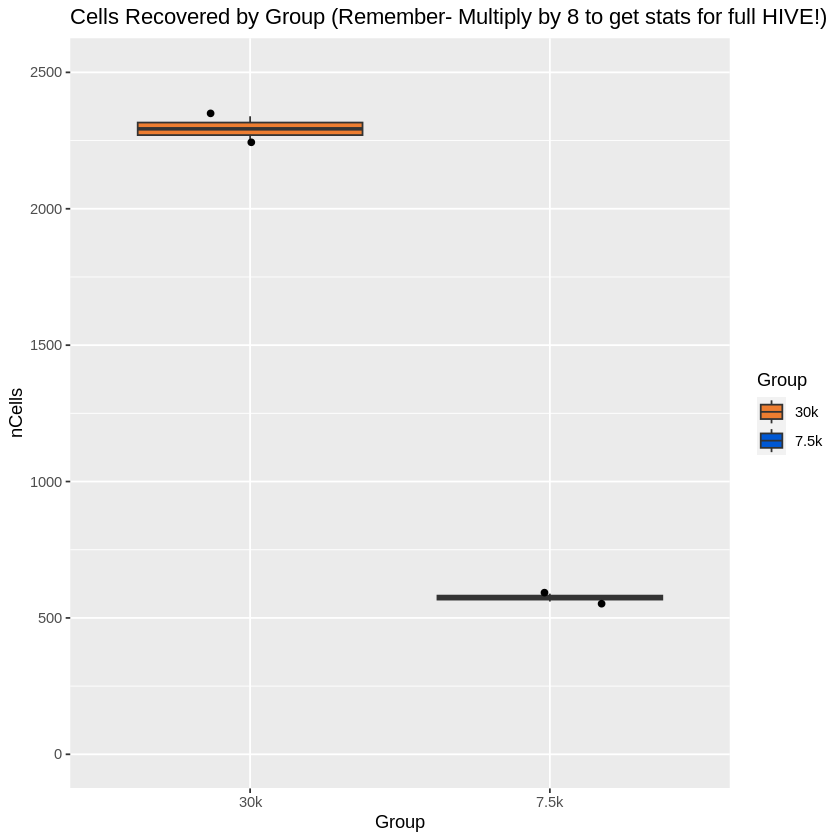

In [23]:
p <- ggplot(sample_metrics, aes(Group, nCells)) + 
  ggtitle("Cells Recovered by Group (Remember- Multiply by 8 to get stats for full HIVE!)")

# calculate axis limits for plots
yL=500*ceiling(max(sample_metrics$nCells/500))

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL))

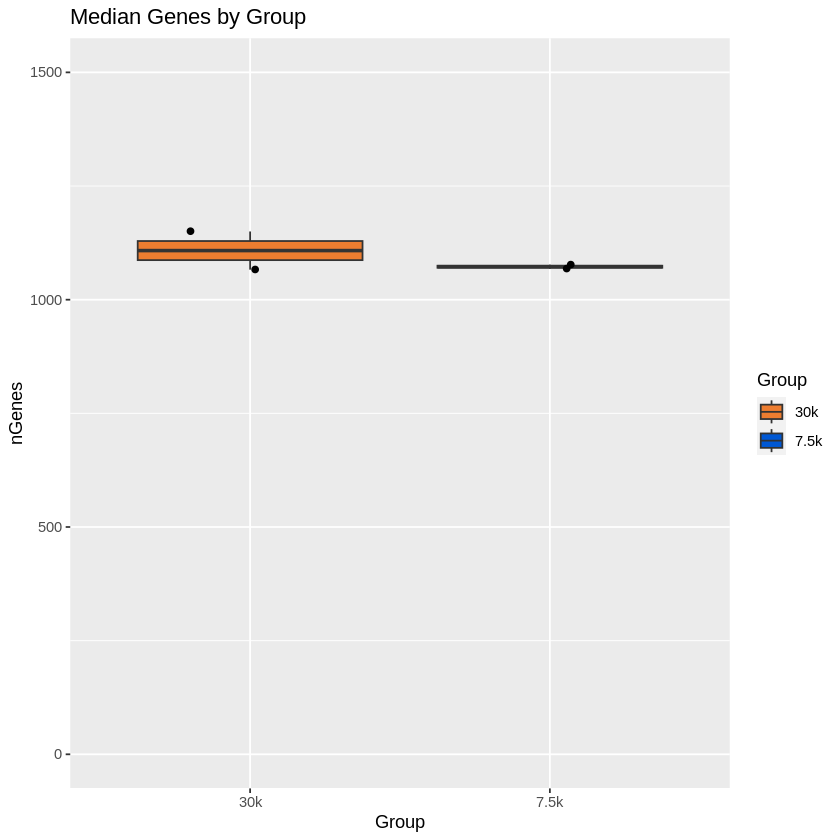

In [24]:
p <- ggplot(sample_metrics, aes(Group, nGenes)) + 
  ggtitle("Median Genes by Group")

# calculate axis limits for plots
yL=500*ceiling(max(sample_metrics$nGenes)/500) 

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

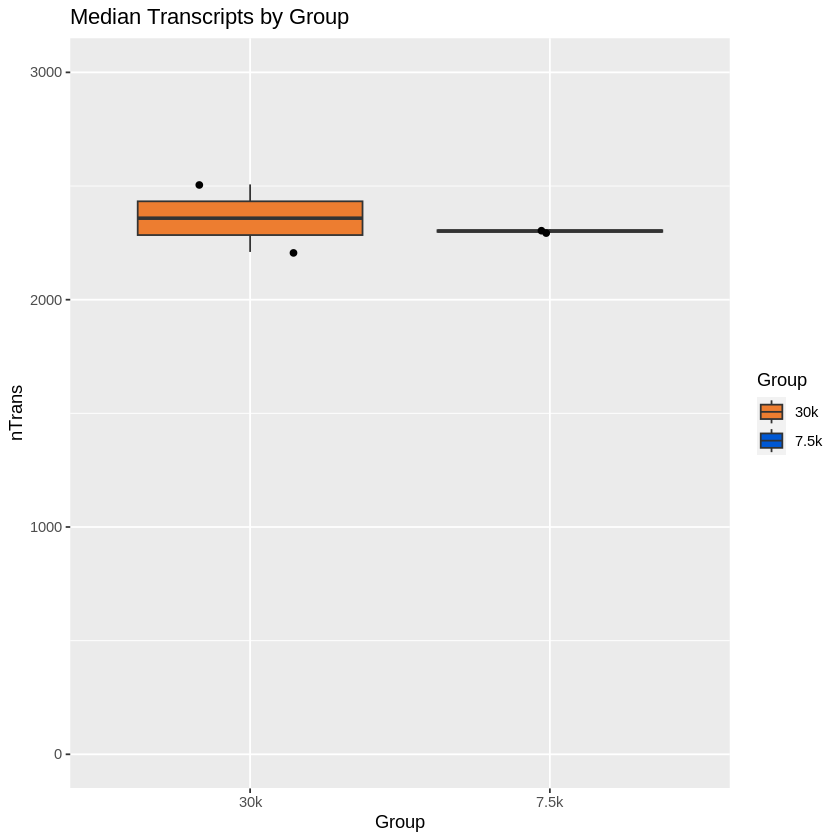

In [25]:
p <- ggplot(sample_metrics, aes(Group, nTrans)) + 
  ggtitle("Median Transcripts by Group")

# calculate axis limits for plots
yL=500*ceiling(max(sample_metrics$nTrans)/500) 

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

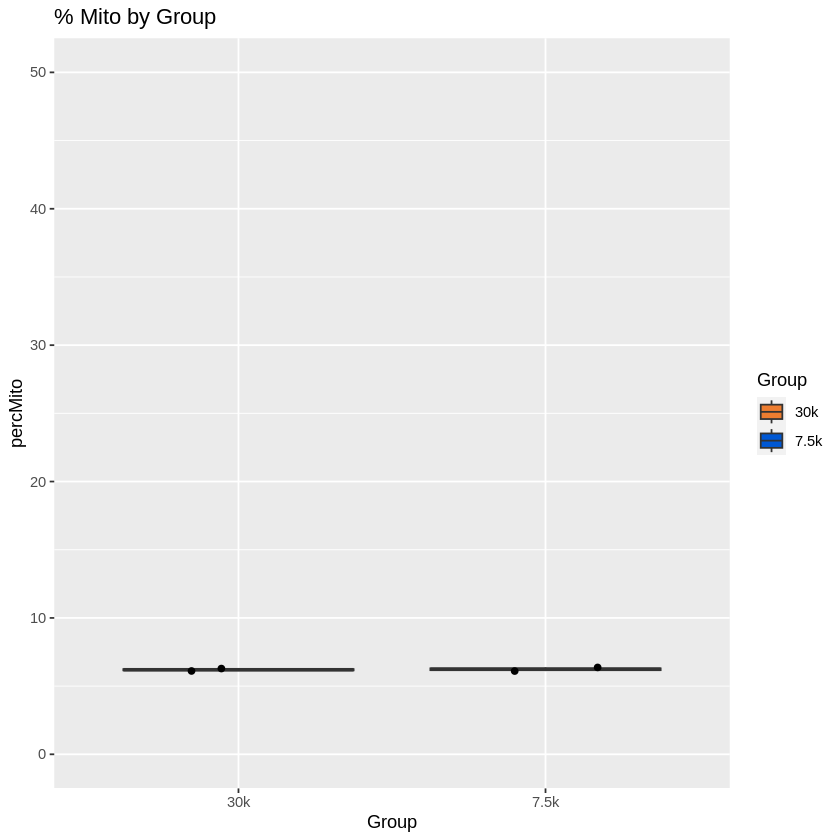

In [26]:
p <- ggplot(sample_metrics, aes(Group, percMito)) + 
  ggtitle("% Mito by Group")

yL=50

p + geom_boxplot(outlier.shape = NA, aes(fill = Group) ) + 
  scale_fill_manual(values=colors) + 
  geom_jitter(width = 0.2) + 
  ylim(c(0,yL)) 

#### **1.5 Dimensionality Reduction** ####

In [27]:
## Dimensionality Reduction
obj <- NormalizeData(obj)
obj <- ScaleData(obj)
obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 2000)
obj <- RunPCA(obj, verbose = FALSE)
obj <- RunUMAP(obj, dims=1:30,verbose = FALSE)
obj <- FindNeighbors(obj,verbose = FALSE)
obj <- FindClusters(obj, verbose = FALSE)
obj <- BuildClusterTree(obj,reorder=TRUE,reorder.numeric=TRUE)
obj$seurat_clusters <- obj$tree.ident

#Run SCTransform if percent.mito is present in metadata
if (is.null(mito.genes)==FALSE){
    obj <- SCTransform(obj, vars.to.regress = "percent.mito", verbose = FALSE)
} else {
    obj <- SCTransform(obj, verbose = FALSE)
}
obj <- RunPCA(obj, verbose = FALSE)
obj <- RunUMAP(obj, dims=1:18,verbose = FALSE)
obj <- FindNeighbors(obj,verbose = FALSE)
obj <- FindClusters(obj, verbose = FALSE)
obj <- BuildClusterTree(obj,reorder=TRUE,reorder.numeric=TRUE)
obj$seurat_clusters <- obj$tree.ident

Normalizing layer: counts.SC_NP_H_7061

Normalizing layer: counts.SC_NP_H_7063

Centering and scaling data matrix

Finding variable features for layer counts.SC_NP_H_7061

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.6816”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.31989”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.031008”
Finding variable features for layer counts.SC_NP_H_7063

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“at  -0.49026”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“radius  0.00017271”
Warning message in simpleLoess(y, x, w, span,

ERROR: Error in irlba(A = t(x = object), nv = npcs, ...): max(nu, nv) must be strictly less than min(nrow(A), ncol(A))


##### **1.5.1 UMAP Plots** #####
###### **1.5.1.1 Clusters** ######

In [28]:
DimPlot(obj, reduction="umap")

ERROR: [1m[33mError[39m in `object[[reduction]]`:[22m
[33m![39m ‘umap’ not found in this Seurat object
 


In [29]:
#The UMAP can be colored or split by sample or group

DimPlot(obj, reduction="umap", group.by = "orig.ident")

ERROR: [1m[33mError[39m in `object[[reduction]]`:[22m
[33m![39m ‘umap’ not found in this Seurat object
 


In [30]:
DimPlot(obj, reduction="umap", group.by = "group")

ERROR: [1m[33mError[39m in `object[[reduction]]`:[22m
[33m![39m ‘umap’ not found in this Seurat object
 


In [31]:
DimPlot(obj, reduction="umap", split.by = "group")

ERROR: [1m[33mError[39m in `object[[reduction]]`:[22m
[33m![39m ‘umap’ not found in this Seurat object
 


###### **1.5.1.2 Cell Features** ######
Feature plots can be used to plot most variables in your dataset. You can use this plot for genes and transcripts, but can also use these plots to plot expression of your favorite gene!

In [32]:
features <- c("nCount_RNA", "nFeature_RNA","percent.mito","CD8A")
FeaturePlot(obj, features = features)

ERROR: [1m[33mError[39m in `DefaultDimReduc()`:[22m
[33m![39m Unable to find a DimReduc matching one of 'umap', 'tsne', or 'pca'; please specify a dimensional reduction to use


##### **1.5.2 Violin Plot** #####
Here we look at the number of transcripts detected in each cell, broken out by cluster. Once clustering is performed, the “identity” of each cell barcode is its cluster number, which is why this graph is separated by cluster. You can change identities of the cell at any time (See the next section on how to change the identity to “cell type”)

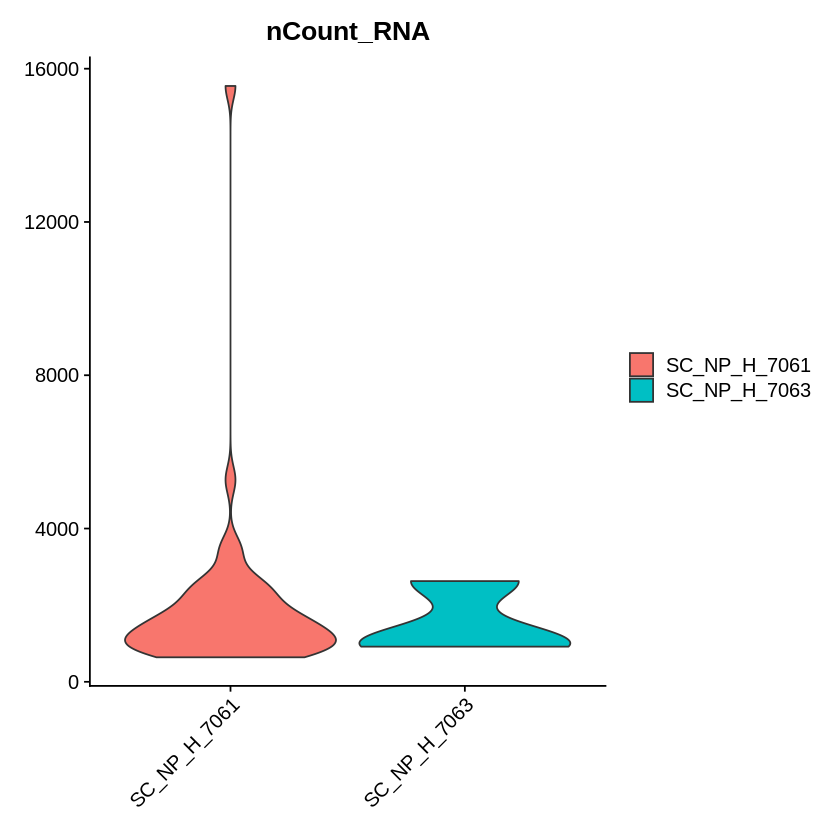

In [33]:
VlnPlot(obj, features = 'nCount_RNA', pt.size = 0) +
  theme(axis.title.x = element_blank())

##### **1.5.3 scType - Cell Type Identification** #####
For a preliminary cell type ID, we use scType (https://github.com/IanevskiAleksandr/sc-type). This annotator works best for human and mouse samples but may also apply to other reference genomes.

In [34]:
# Access the RNA assay of the Seurat object
rna_assay <- obj$RNA

# Get the gene names (rownames of the RNA assay)
gene_names <- rownames(rna_assay)

# Print the first few gene names
gene_names

[1] "5S-rRNA"                   "7SK"                      
    [3] "A2ML1"                     "A2MP1"                    
    [5] "A4GALT"                    "AAAS"                     
    [7] "AACS"                      "AACSP1"                   
    [9] "AADACP1"                   "AADAT"                    
   [11] "AAGAB"                     "AAK1"                     
   [13] "AAMDC"                     "AAMP"                     
   [15] "AAR2"                      "AARS1"                    
   [17] "AARS2"                     "AARSD1"                   
   [19] "AASDH"                     "AASDHPPT"                 
   [21] "AASS"                      "AATF"                     
   [23] "ABAT"                      "ABCA1"                    
   [25] "ABCA11P"                   "ABCA12"                   
   [27] "ABCA13"                    "ABCA2"                    
   [29] "ABCA4"                     "ABCA5"                    
   [31] "ABCA6"                     "ABCA7"                    
   [33] "ABCA9"                     "ABCB10"                   
   [35] "ABCB11"                    "ABCB4"                    
   [37] "ABCB6"                     "ABCB7"                    
   [39] "ABCB8"                     "ABCB9"                    
   [41] "ABCC1"                     "ABCC3"                    
   [43] "ABCC5"                     "ABCC6"                    
   [45] "ABCC6P1"                   "ABCC8"                    
   [47] "ABCC9"                     "ABCD1"                    
   [49] "ABCD3"                     "ABCD4"                    
   [51] "ABCE1"                     "ABCF1"                    
   [53] "ABCF2"                     "ABCG1"                    
   [55] "ABCG5"                     "ABHD11"                   
   [57] "ABHD11-AS1"                "ABHD12"                   
   [59] "ABHD12B"                   "ABHD13"                   
   [61] "ABHD14A-ACY1"              "ABHD14B"                  
   [63] "ABHD16A"                   "ABHD17A"                  
   [65] "ABHD17AP6"                 "ABHD17B"                  
   [67] "ABHD17C"                   "ABHD2"                    
   [69] "ABHD4"                     "ABHD5"                    
   [71] "ABI1"                      "ABI2"                     
   [73] "ABITRAM"                   "ABL1"                     
   [75] "ABL2"                      "ABLIM1"                   
   [77] "ABO"                       "ABR"                      
   [79] "ABRACL"                    "ABRAXAS1"                 
   [81] "ABRAXAS2"                  "ABTB1"                    
   [83] "ACAA1"                     "ACAA2"                    
   [85] "ACACA"                     "ACACB"                    
   [87] "ACAD10"                    "ACAD11"                   
   [89] "ACAD8"                     "ACAD9"                    
   [91] "ACADL"                     "ACADM"                    
   [93] "ACADS"                     "ACADVL"                   
   [95] "ACAP1"                     "ACAP2"                    
   [97] "ACAP3"                     "ACAT1"                    
   [99] "ACAT2"                     "ACBD3"                    
  [101] "ACBD3-AS1"                 "ACBD4"                    
  [103] "ACBD5"                     "ACBD6"                    
  [105] "ACBD7"                     "ACCS"                     
  [107] "ACCSL"                     "ACER3"                    
  [109] "ACIN1"                     "ACLY"                     
  [111] "ACO2"                      "ACOT11"                   
  [113] "ACOT13"                    "ACOT2"                    
  [115] "ACOT4"                     "ACOT8"                    
  [117] "ACOT9"                     "ACOX1"                    
  [119] "ACOX3"                     "ACP1"                     
  [121] "ACP2"                      "ACP5"                     
  [123] "ACP6"                      "ACRBP"                    
  [125] "ACSBG1"                    

In [35]:
# Set the working directory
setwd("/media/asus/275dd380-2319-4638-bcdd-5f65b2b1d4b5/CHRF_Project_Data/Single_Cell/Honeycomb_Biotechnologies/Data_Analysis/3_Additional_Analysis_Resources/4_Seurat_Analysis_Tutorial")

# Source the local R script files
source("sc-type/R/gene_sets_prepare.R")
source("sc-type/R/sctype_score_.R")
source("sc-type/R/auto_detect_tissue_type.R")

# Make sure your Seurat object 'obj' is already loaded here
# If not, load or create your Seurat object 'obj'

# Scale the data in the Seurat object
# obj <- ScaleData(obj, features = rownames(obj@assays$RNA))

# Load the marker genes and predict the dataset's tissue type
db_ = "./ScTypeDB_full_v1.xlsx"
tissue_guess = auto_detect_tissue_type(path_to_db_file = db_, 
                                       seuratObject = obj, 
                                       scaled = TRUE, 
                                       assay = "RNA")


[1] "Checking...Pancreas"


Warning message in checkGeneSymbols(markers_all):
“Human gene symbols should be all upper-case except for the 'orf' in open reading frames. The case of some letters was corrected.”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': no slot of name "scale.data" for this object of class "Assay5"


In [36]:
obj <- ScaleData(obj, features = rownames(obj))


Centering and scaling data matrix



In [37]:
## Download the reference scripts and mar
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/gene_sets_prepare.R")
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/sctype_score_.R")
source("https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/R/auto_detect_tissue_type.R")

# load the marker genes for all tissue types and have scType predict the right dataset
db_ = "https://raw.githubusercontent.com/IanevskiAleksandr/sc-type/master/ScTypeDB_full.xlsx";
tissue_guess = auto_detect_tissue_type(path_to_db_file = db_, 
                                       seuratObject = obj, 
                                       scaled = TRUE, 
                                       assay = "RNA")

[1] "Checking...Immune system"


Warning message in checkGeneSymbols(markers_all):
“Human gene symbols should be all upper-case except for the 'orf' in open reading frames. The case of some letters was corrected.”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in checkGeneSymbols(markers_all):
“x contains non-approved gene symbols”
Warning message in

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': no slot of name "scale.data" for this object of class "Assay5"


In [ ]:
tissue<- tissue_guess[1,1]
# prepare gene sets
gs_list = gene_sets_prepare(db_, tissue)

es.max = sctype_score(scRNAseqData = obj[["RNA"]]@scale.data, 
                      scaled = TRUE, 
                      gs = gs_list$gs_positive, 
                      gs2 = gs_list$gs_negative) 

# merge by cluster
cL_resutls = do.call("rbind", lapply(unique(obj@meta.data$seurat_clusters), function(cl){
    es.max.cl = sort(rowSums(es.max[ ,rownames(obj@meta.data[obj@meta.data$seurat_clusters==cl, ])]), decreasing = !0)
    head(data.frame(cluster = cl, type = names(es.max.cl), scores = es.max.cl, ncells = sum(obj@meta.data$seurat_clusters==cl)), 10)
}))
sctype_scores = cL_resutls %>% group_by(cluster) %>% top_n(n = 1, wt = scores)  

# set low-confident (low ScType score) clusters to "unknown"
sctype_scores$type[as.numeric(as.character(sctype_scores$scores)) < sctype_scores$ncells/4] = "Unknown"
print(sctype_scores[,1:3])

In [ ]:
# save old idents for reference
obj[["old.ident"]] <- Idents(object = obj)


obj@meta.data$customclassif = ""
        for(j in unique(sctype_scores$cluster)){
            cl_type = sctype_scores[sctype_scores$cluster==j,]; 
            obj@meta.data$customclassif[obj@meta.data$seurat_clusters == j] = as.character(cl_type$type[1])
        }
        
obj[["cell_type"]]<- obj$customclassif
write.table(sctype_scores, file = "sctype_scores.txt", quote = F, sep = "\t")

## Change the cell identity to "cell-type"
Idents(obj)<- obj$cell_type

## Visualise as umap
DimPlot(obj, reduction="umap", group.by = "cell_type")

In [ ]:
## display a table of the results
datatable(sctype_scores)
Show 
10
 entriesSearch:


#### **1.6 Differential Gene Expression Analysis** ####
The table below shows the the genes expressed in each cluster versus. all other clusters. You can change the Idents to change the grouping for the marker gene analysis.

- > p_val: the p value from the Wilcoxon rank sum test
- > avg_log2FC: log2 fold change
- > pct.1: percent of cells expressing the indicated gene in the cluster specified in the “cluster” column
- > pct.2: percent of all other cells in the other clusters that express the indicated gene
- > p_val_adj: Bonferroni corrected p-values
- > cluster: the specific cluster that is being evaluated

In [ ]:
DefaultAssay(obj) <- "RNA"
Idents(obj)<- obj$seurat_clusters
markers <- FindAllMarkers(obj, 
                          logfc.threshold = 0.25,
                          test.use = "wilcox",
                          min.pct = 0.25)
datatable(markers)

#### **1.7 Save R environment** ####
Consider saving your Seurat object and other variables for future use with the following code.

In [ ]:
# Fill in the name of the data set below

save(obj, nGeneI, nTranI, sampleslsit, groupslist, totReads.df, markers, sctype_scores,
     file = "Name_of_Dataset.Rdata")